# Progresa Impact Estimation

## Introduction to the project

The goal of this project is to implement some of the econometric techniques to measure the impact of Progresa on secondary school enrollment rates. <br>
Throughout this notebook, I will go through; <br>
1. **Descriptive analysis** : Check the dataset's characteristics and baseline information.
2. **Simple difference** : Estimate the causal impact by simple difference, by tabular analysis and regression.
3. **Difference-in-difference** : Re-estimate the causal effect by Difference-in-Difference, the method which is more suitable for this dataset.

For this project, I used data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico.<br>
 This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz. 



### The timeline of the Progresa program:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of surveys conducted in 1998
 * "Wave 2" of surveys conducted in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
The data are actual data collected to evaluate the impact of the Progresa program. In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |labeled poor: pobre = 1, no pobre = 0|
|progresa |treatment : basal =1, '0' = 0|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|
|grc97  |grade enrolled in 1997

---

# 1. Descriptive analysis

### Data Exploration & null check

I checked some statistics (mean, median and standard deviation) for all of the demographic variables in the dataset. 
Also checked null values of each column.


In [8]:
# import libraries
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#import dataset
df = pd.read_csv('progresa_sample.csv')

#Take a look 
df.head()

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
0,97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,1,7,1.0
1,98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,14,163,1,7,1.0
2,97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,12,163,2,6,1.0
3,98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,2,6,1.0
4,97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,8,163,3,2,1.0


In [9]:
#Check null values.
for col in df.columns:
    print(f'dtype of {col} is {type(df[col][0])}. Missing {df[col].isnull().sum()} values.')

dtype of year is <class 'numpy.int64'>. Missing 0 values.
dtype of sex is <class 'numpy.float64'>. Missing 24 values.
dtype of indig is <class 'numpy.float64'>. Missing 300 values.
dtype of dist_sec is <class 'numpy.float64'>. Missing 0 values.
dtype of sc is <class 'numpy.float64'>. Missing 8453 values.
dtype of grc is <class 'numpy.float64'>. Missing 6549 values.
dtype of fam_n is <class 'numpy.int64'>. Missing 0 values.
dtype of min_dist is <class 'numpy.float64'>. Missing 0 values.
dtype of dist_cap is <class 'numpy.float64'>. Missing 0 values.
dtype of poor is <class 'str'>. Missing 0 values.
dtype of progresa is <class 'str'>. Missing 0 values.
dtype of hohedu is <class 'numpy.int64'>. Missing 0 values.
dtype of hohwag is <class 'numpy.float64'>. Missing 0 values.
dtype of welfare_index is <class 'numpy.float64'>. Missing 210 values.
dtype of hohsex is <class 'numpy.float64'>. Missing 20 values.
dtype of hohage is <class 'numpy.float64'>. Missing 10 values.
dtype of age is <class

In [10]:
#Map some variables for convenience
df['poor'] = df['poor'].map({'pobre': 1, 'no pobre': 0})
df['progresa'] = df['progresa'].map({'0': 0, 'basal': 1})

#Make a demographic data table
demo = df.drop(axis= 1, columns = ['year','folnum', 'village'])
cols = demo.columns.sort_values(ascending= True)
demo = demo[cols]

In [11]:
#Make a table with mean, std, median for each variable
mean = []
std = []
median = []

for col in cols:
    mean.append(demo[col].mean())
    std.append(demo[col].std())
    median.append(demo[col].median())
    
summ = pd.DataFrame([mean, std, median], columns = cols, index = ['mean', 'std', 'median'])
summ

,age,dist_cap,dist_sec,fam_n,grc,grc97,hohage,hohedu,hohsex,hohwag,indig,min_dist,poor,progresa,sc,sc97,sex,welfare_index
mean,11.366460,147.674452,2.418910,7.215715,3.963537,3.705372,44.436717,2.768104,0.925185,586.985312,0.298324,103.447520,0.846498,0.615663,0.819818,0.813922,0.512211,690.346564
std,3.167744,76.063134,2.234109,2.352900,2.499063,2.572387,11.620372,2.656106,0.263095,788.133664,0.457525,42.089441,0.360473,0.486441,0.384342,0.389172,0.499854,139.491130
median,11.000000,132.001494,2.279000,7.000000,4.000000,4.000000,43.000000,2.000000,1.000000,500.000000,0.000000,111.228612,1.000000,1.000000,1.000000,1.000000,1.000000,685.000000


### Differences at baseline?

Next, I will check the baseline (1997) demographic characteristics **for the poor**  different in treatment and control groups.<br>
I used a T-Test (p = 0.05 as threshold) to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset.



In [17]:
#Get the average of each variable for treatment and control group, respectively. 
variables = ['age', 'dist_cap', 'dist_sec', 'fam_n', 'grc97', 'hohage', 'hohedu', 'hohsex', 'hohwag', 'indig','progresa', 'min_dist','sc97', 'sex', 'welfare_index']

base = df[(df['year'] == 97) &  (df['poor'] == 1)][variables].groupby(by = 'progresa').mean().transpose()
base['diff'] = base[1] - base[0]

In [18]:
#show the difference in table

p_values = []

vals = ['age', 'dist_cap', 'dist_sec', 'fam_n', 'grc97', 'hohage', 'hohedu', 'hohsex', 'hohwag', 'indig', 'min_dist','sc97', 'sex', 'welfare_index']
for val in vals:
    p_values.append(round(
        scipy.stats.ttest_ind(
            a = df[(df['year'] == 97) & (df['poor'] == 1) & (df['progresa'] == 1)][val],
            b = df[(df['year'] == 97) & (df['poor'] == 1) & (df['progresa'] == 0)][val],
            equal_var = False, #I chose to do Welch's t-test, meaning do not assume that these two samples have the same variance.
            nan_policy = 'omit' #ignore null and compute
        )[1],4)
    )


base['p-value'] = np.array(p_values)
base.columns = ['Control','Treatment', 'Difference', 'p_value']
base[['Treatment','Control', 'Difference', 'p_value']] 

,Treatment,Control,Difference,p_value
age,10.716991,10.742023,-0.025032,0.4784
dist_cap,150.829074,153.769730,-2.940656,0.0011
dist_sec,2.453122,2.507662,-0.054540,0.0427
fam_n,7.281327,7.302469,-0.021142,0.4290
grc97,3.531599,3.543050,-0.011450,0.6895
hohage,43.648828,44.276918,-0.628090,0.0000
hohedu,2.663139,2.590348,0.072791,0.0104
hohsex,0.924656,0.922947,0.001709,0.5721
hohwag,544.339544,573.163558,-28.824015,0.0003
indig,0.325986,0.332207,-0.006222,0.2459


**Note**

- According to the result of t-test, there are variables whose p-value is below 0.05. If we set our thresholds at 0.05, we can reject the hypothesis that these two sample groups have no stasitically significant difference. In other words, the selection of these two groups could be biased.
- Since there could be statistically significant differences between these two groups, we can't use single difference between treatment and control, or pre-post comparison that require 0 difference at baseline.  
- We need to choose the method that allows us to assume the difference in the treatment and control groups at baseline.

---

# 2. Simple Difference

My goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico.<br> 
We will focus on the impact of the program on school enrollment rates among the poor (those with poor== 1), <br>
since only the poor were eligible to receive PROGRESA assistance, and since a primary objective of the program was to increase school enrollment.

### Simple difference(1): Tabular Analysis & T-test

Let's begin by estimating the impact of Progresa using "simple differences." <br>
Simple difference is a very straight forward approach. We simple going to compare the outcomes of treatment and control group, or pre and post periods.<br>
This method is simple and easy to understand, but requires the strong assumption to generate unbiased estimate.<br>
Its underlying assumption is "The counterfactual assumption is that, in the absence of treatment, the average school enrollment in the treatment group and the average school enrollment in the control groups would have been the same."<br>
As we already saw there could be a selection bias between treatment and control group, so we need to keep in mind that this method will lead to biased estimation.<br><br><br>


First, I calculated the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages in 1998, and then used T-test to see its statistics significance.

In [129]:
#Compute the difference 
ave_sc_t = df[(df['year'] == 98) & (df['poor'] == 1) & (df['progresa'] == 1)]['sc']
ave_sc_c = df[(df['year'] == 98) & (df['poor'] == 1) & (df['progresa'] == 0)]['sc']

p_val = scipy.stats.ttest_ind(a = ave_sc_t, b = ave_sc_c, equal_var= False, nan_policy='omit')[1]

print(f'Average enrollment rate of the treatment group {ave_sc_t.mean()}'  )
print(f'Average enrollment rate of the control group is {ave_sc_c.mean()}')
print(f'Difference is {ave_sc_t.mean() - ave_sc_c.mean()}')
print(f'P-value of the null hypothesis is {p_val}')

Average enrollment rate of the treatment group 0.8464791213954308
Average enrollment rate of the control group is 0.807636956730308
Difference is 0.0388421646651228
P-value of the null hypothesis is 2.9655072988948406e-16


*Note*

- p-value is nearly 0, way below 5%.
- This simple difference implies that progresa had a causal impact to the average enrollment rate on the treatment villages. (3.88%)

### Simple difference(2): Regression

Now, let's estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. 

In [131]:
# Run Multiple Regression
vals = ['age', 'dist_cap', 'dist_sec', 'fam_n', 'grc', 'hohage', 'hohedu', 'hohsex', 'hohwag', 'indig', 'min_dist','progresa','sex','sc','welfare_index']
mul = df[(df['year'] == 98) & (df['poor'] == 1)][vals].dropna(axis = 0)

X = pd.get_dummies(mul.drop(axis = 1, columns = ['sc']), columns = ['indig','sex'], drop_first= True, dtype= 'int')
X = sm.add_constant(X)
y = mul['sc']
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     847.0
Date:                Sat, 03 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:41:45   Log-Likelihood:                -6928.7
No. Observations:               27200   AIC:                         1.389e+04
Df Residuals:                   27185   BIC:                         1.401e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6540      0.020     84.276

*Note*

- The coefficient of treatment is **0.0319**, this implies that if one poor household receives progresa treatment, then their likelihood of school enrollment will increse by 3.19%.
- For example, for every 10,000 poor children, **319** more children newly started schooling because of progresa.
- P-value of progresa coefficient is very small (less than 0.05), so we can reject the null hypothesis that this coefficient is likely to equal to zero.

---
# 3. Difference-in-Difference

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages.<br> 
An alternative approach would be to compute the treatment effect using a **Difference-In-Differences(DID)** framework.<br>
The DID method is an approach to estimate causal effects under the selection bias between treatment and control group.<br><br>

The underlying assumption of DID is, "there exist parallel trends over time in enrollment rates between treated and control villages."<br>
So it doesn't require the assumption Simple difference requires, which is "Treatment group and control group would have the same **outcome** in the absence of treatment."<br>
Although we need pre-period data to execute this method, this advantage on assumption is critical about impact evaluation in reality,<br> 
especially because we already know there could be a selection bias between treatment and control group of this dataset.


### Difference-in-Difference(1): Tabular Analysis

Let's begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998.<br>
Specifically, I calculated the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. 

In [133]:
#Tabular Analysis for DID
post_t = df[(df['year'] == 98) & (df['poor'] == 1) & (df['progresa'] == 1)]['sc'].mean()
pre_t = df[(df['year'] == 97) & (df['poor'] == 1) & (df['progresa'] == 1)]['sc'].mean()
post_c = df[(df['year'] == 98) & (df['poor'] == 1) & (df['progresa'] == 0)]['sc'].mean()
pre_c = df[(df['year'] == 97) & (df['poor'] == 1) & (df['progresa'] == 0)]['sc'].mean()


print(f'A diff in treatment is {post_t - pre_t}')
print(f'A diff in control is {post_c - pre_c}')
print(f'A diff-diff is {(post_t - pre_t) - (post_c - pre_c)}')

table = pd.DataFrame([[pre_c, post_c],[pre_t , post_t]], columns = ['1997','1998'], index=['Control', 'Treatment'])
table

A diff in treatment is 0.023782233992046597
A diff in control is -0.007549046327276487
A diff-diff is 0.031331280319323085


,1997,1998
Control,0.815186,0.807637
Treatment,0.822697,0.846479


*Note*
- DID effect is 0.0313, almost the same as the previous one but it's slightly smaller.
- The underlying assumption is that treatment group and control group have the same trend in the abscence of the treatment.

### Difference-in-Difference(2): Regression

Now I use a regression specification to estimate the average treatment effects of the program in a difference-in-differences, for the poor households.

In [21]:
#Differenc in Difference Method
vals = ['year','age', 'dist_cap', 'dist_sec', 'fam_n', 'grc', 'hohage', 'hohedu', 'hohsex', 'hohwag', 'indig', 'min_dist','progresa','sex','sc','welfare_index']
df_did = df[df['poor'] == 1][vals].dropna(axis= 0)
df_did['year'] = df_did['year'].map({98 : 1, 97 : 0})

#Make an intersection term
df_did['did'] = df_did['year'] * df_did['progresa']
X = sm.add_constant(df_did.drop(axis = 1, columns = ['sc']))

y = df_did['sc']
model = sm.OLS(y, X).fit()
print(f"DID estimator is {model.params['did']}")
print(model.summary())


DID estimator is 0.02915726848791441
                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     1631.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:28:47   Log-Likelihood:                -15320.
No. Observations:               57938   AIC:                         3.067e+04
Df Residuals:                   57921   BIC:                         3.083e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const    

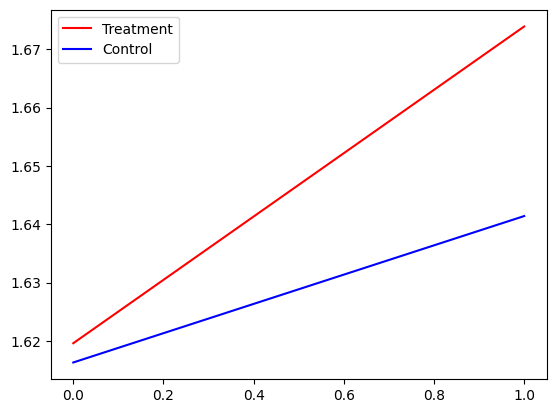

In [24]:
#Visualize it
const = 1.6163
year = 0.0251
progresa = 0.0033
did =  0.0292

x = np.array([0, 1])
y_t = const + year * x + progresa + did * x
y_c = const + year * x
plt.plot(x, y_t, color = 'red', label = "Treatment")
plt.plot(x, y_c, color = 'blue', label = "Control")
plt.legend()

*Note*
- The DID estimator of is 0.0292, meaning the treatment increases the likelihood of child's enrollment of each household by 2.92%.
- In other words, for every 10,000 children from poor households, 292 more children newly started schooling because of progresa.
- Compared to the result of simple difference (0.319), the DID estimator is smaller by 0.0027. This indicates **the simple difference overestimated the causal effect of treatment.**

# Conclusion

- As long as standing with the assumption that the treatment group and control group have the same trend in the absence of the treatment, the double differences method can estimate an unbiased causal impact.
- Thus, according to DID regression, we can claim that the Progresa had a causal impact on the enrollment rates of poor households, *by 2.92%.*
- Other methods, such as simple differences, have serious flaws in their underlying assumptions and thus overestimated the causal impact up *3.19%*
- It is really important to be aware of the underlying assumption of the method we use, and the limitation of perfect random assignment!

# Thank you for listening!